<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg"  width=400></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

In [0]:
import torch
from torch import nn
from torch import functional as F

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Дисклеймер про CrossEntropyLoss и NLLLoss

Обычно в PyTorch не нужно делать Softmax как последний слой модели. 

* Если Вы используете NLLLoss, то ему на вход надо давать лог вероятности, то есть выход слоя LogSoftmax. (Просто результат софтмакса, к которому применен логарифм)
* Если Вы используете CrossEntropyLoss, то применение LogSoftmax уже включено внутрь лосса, поэтому ему на вход надо подавать просто выход обычного линейного слоя без активации. По сути CrossEntropyLoss = LogSoftmax + NLLLoss

Зачем такие сложности, чтобы посчитать обычную кросс энтропию, которую мы использовали как лосс еще в логистической регрессии? Дело в том, что нам в любом случае придется взять логарифм от результатов софтмакса, а если делать это одной функцией, то можно сделать более устойчивую реализацию, которая даст меньшую вычислительную погрешность. 

Таким образом, если у вас в конце сети, решающей задачу классификации, стоит просто линейный слой без активации, то вам нужно использовать CrossEntropy. В этой домашке везде используется лосс CrossEntropy

# 1. Создайте генератор батчей. 

В этот раз мы хотим сделать генератор, который будет максимально похож на то, что используется в реальном обучении. 

С помощью numpy вам нужно перемешать исходную выборку и выбирать из нее батчи размером batch_size, если размер выборки не делился на размер батча, то последний батч должен иметь размер меньше batch_size и состоять просто из всех оставшихся объектов. Возвращать нужно в формате (X_batch, y_batch)


**Ответ на задание - код**

In [0]:
from google.colab import drive
drive.mount('/gdrive')

data = pd.read_csv('/gdrive/My Drive/sky_data.csv')
data['class'].value_counts()


feature_columns = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'camcol', 'field']
target_column = 'class'

target_mapping = {
    'GALAXY': 0,
    'STAR': 1,
    'QSO': 2
}

# Extract Features
X = data[feature_columns]
# Extract target
y = data['class']

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
type features:  <class 'pandas.core.frame.DataFrame'>
           ra       dec         u         g  ...         z  run  camcol  field
0  183.531326  0.089693  19.47406  17.04240  ...  15.22531  752       4    267
1  183.598371  0.135285  18.66280  17.21449  ...  16.39150  752       4    267
2  183.680207  0.126185  19.38298  18.19169  ...  16.80125  752       4    268
3  183.870529  0.049911  17.76536  16.60272  ...  15.90438  752       4    269
4  183.883288  0.10255

In [0]:
def batch_generator(X, y, batch_size):
    np.random.seed(42)
    perm = np.random.permutation(len(X))
    data_size = len(X)
    X = X[perm]
    y = y[perm]

    for offset in range(0, data_size, batch_size):
        X_batch = X[offset : offset + batch_size]
        y_batch = y[offset : offset + batch_size]
        yield (X_batch, y_batch)

<class 'generator'>
<generator object batch_generator at 0x7f945565b308>


# 2. Обучите модель для классификации звезд

Загрузите датасет из файла sky_data.csv, разделите его на train/test и обучите на нем нейронную сеть (архитектура ниже). Обучайте на батчах с помощью оптимизатора Adam со lr=1e-2. 

Архитектура:

1. Dense Layer с relu активацией и 50 нейронами
2. Dropout with 50% keep rate
3. BatchNorm
4. Dense Layer с relu активацией и 100 нейронами
5. Dropout with 50% keep rate
6. BatchNorm
7. Выходной Dense слой c количеством нейронов, равному количеству классов

Лосс - CrossEntropy.

**В качестве ответа введите число - среднее предсказание 0 класса на тестовом датасете (т.е. выход модели для 0 класса, где среднее берется по предсказаниям для всех строчек из теста)**

В датасете классы - строчки, поэтому чтобы ответ совпал с ответом на степике надо каким-то детерминированным образом его закаодировать. Для этого в строчке ниже объявлен dict, с помощью него и функции map превратите столбец с таргетом в целое число.

Загрузка данных

In [0]:
# encode target with target_mapping

# Writing velosipedos, why not?
def encode_trg_wth_map(target, map):
  import copy
  map_encode_target = list(target)

  for i in range (len(map_encode_target)):
    for get_key, get_value in map.items():
      if map_encode_target[i] == get_key:
        map_encode_target[i] = get_value

  return (map_encode_target)

#y = encode_trg_wth_map(y, target_mapping)
y = y.replace(target_mapping)

0       1
1       1
2       0
3       1
4       1
       ..
9995    0
9996    0
9997    1
9998    0
9999    0
Name: class, Length: 10000, dtype: int64


Нормализация фичей

In [0]:
# Просто вычтите среднее и поделитe на стандартное отклонение (с помощью пандас)

X_for_norm_func = pd.DataFrame(X.values[:,:])

def norm_features_pandas(X):
    import copy
    new_features = copy.deepcopy(X)
    for i in range (X.shape[1]):
        mean_column = (X.values[:, i]).mean()
        std_column = (X.values[:, i]).std()
        for j in range (len(X)):  
            if std_column != 0:      
                new_features[i][j] = (new_features[i][j] - mean_column) / std_column
            else:
                new_features[i][j] = 0
    return new_features

#X = norm_features_pandas(X_for_norm_func)

#SHORT
X_norm = (X_for_norm - X_for_norm.mean()) / X_for_norm.std()

print (X.head(10))

          0         1         2  ...         7         8         9
0  0.167458 -0.584923  1.031486  ... -0.838061  0.210852 -0.217630
1  0.168862 -0.583114  0.052430  ... -0.838061  0.210852 -0.217630
2  0.170574 -0.583475  0.921568  ... -0.838061  0.210852 -0.211479
3  0.174558 -0.586501 -1.030630  ... -0.838061  0.210852 -0.205328
4  0.174825 -0.584412 -1.290232  ... -0.838061  0.210852 -0.205328
5  0.174069 -0.581591  0.979918  ... -0.838061  0.210852 -0.205328
6  0.174429 -0.587719  0.921858  ... -0.838061  0.210852 -0.205328
7  0.175176 -0.581044  0.435154  ... -0.838061  0.210852 -0.205328
8  0.175689 -0.584623 -0.860708  ... -0.838061  0.210852 -0.199177
9  0.176713 -0.585243  0.064125  ... -0.838061  0.210852 -0.199177

[10 rows x 10 columns]


Обучение

In [0]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# Превратим данные в тензоры, чтобы потом было удобнее
X_train = torch.FloatTensor(X_train.values)
y_train = torch.LongTensor(y_train.values)
X_test = torch.FloatTensor(X_test.values)
y_test = torch.LongTensor(y_test.values)

In [0]:
X_test.shape

torch.Size([2500, 10])

Хорошо, данные мы подготовили, теперь надо объявить модель

In [0]:
torch.manual_seed(42) 
np.random.seed(42)
N, D_in, D_out = 500, 10, 3
model = nn.Sequential(
    torch.nn.Linear(D_in, 50),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(50, 100),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(100, D_out),
)
    
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-2

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Теперь обучим модель

In [0]:
def train(num_epoch):
    train_losses = []
    test_losses = []
    for i in range(num_epoch):
        for X_batch, y_batch in batch_generator(X_train, y_train, 500):
            # На лекции мы рассказывали, что дропаут работает по-разному во время обучения и реального предсказания
            # Чтобы это учесть нам нужно включать и выключать режим обучения, делается это командой ниже
            model.train(True)
            
            # Посчитаем предсказание и лосс
            y_pred_batch = model(X_batch)
            batch_loss = loss_fn(y_pred_batch, y_batch)
                       
            # зануляем градиент
            optimizer.zero_grad()

            # backward
            batch_loss.backward()

            # ОБНОВЛЯЕМ веса 
            optimizer.step()
            
            # Запишем число (не тензор) в наши батчевые лоссы ###########
            train_losses.append(float(batch_loss.data))
            
            # Теперь посчитаем лосс на тесте 
            model.train(False)
            y_pred_test = model(X_test)
            test_loss = loss_fn(y_pred_test, y_test)
            #optimizer.zero_grad()
            #train_loss.backward()
            
            # Сюда опять же надо положить именно число равное лоссу на всем тест датасете
            test_losses.append(float(test_loss.data))
            
    return train_losses, test_losses

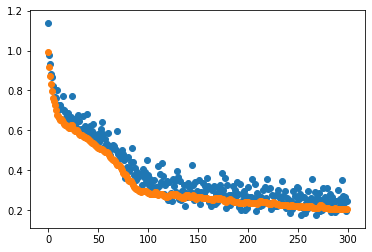

In [0]:
train_losses, test_losses = train(20)
#print(test_losses)
plt.scatter(range(len(train_losses)), train_losses)
plt.scatter(range(len(test_losses)), test_losses)

In [0]:
# Ответ на задачу
model.train(False)
np.mean(test_losses)

0.33313711419701575

# Задание 3

Только что вы обучили полносвязную нейронку, сейчас попробуйте исправить ошибки в созданных ниже нейронках и потом обучить их с помощью той же функции train. Будьте осторожнее и убедитесь, что перед запуском train вы вновь переопределили все необходимые внешние переменные (train обращается к глобальным переменным, в целом так делать не стоит, но сейчас это было оправдано, так как иначе нам пришлось бы передавать порядка 7-8 аргументов).

Чтобы у вас получилась такая же архитектура, как у нас, и ответы совпали, давайте определим некоторые правила, как исправлять ошибки:

1. Если вы видите лишний не линейный слой, который стоит не на своем месте, просто удалите его. (не нужно добавлять новые слои, чтобы сдлеать постановку изначального слоя разумной. Удалять надо самый последний слой, который все портит. Для линейных слоев надо что-то исправить, а не удалить его)
2. Если у слоя нет активации, то добавьте ReLU или другую подходящую активацию
3. Если что-то не так с learning_rate, то поставьте 1e-2
4. Если что-то не так с параметрами, считайте первый параметр, который появляется, как верный (т.е. далее в сети должен использоваться он).
5. Ошибки могут быть и в полносвязных слоях. 
6. Любые другие проблемы решаются более менее однозначно, если же у вас есть серьезные сомнения, то напишите в беседу в телеграме.


Задача все та же - классификация небесных объектов на том же датасете. После исправления сети вам нужно обучить ее.

**Ответ на задачу - средний лосс на тестовом датасете**

In [0]:
torch.manual_seed(42)   
np.random.seed(42)
# RIGHT ARCH
model = nn.Sequential(
    nn.Linear(10, 50),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(50, 200),
    nn.ReLU(),
    nn.Linear(200, 200),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(200, 3),
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

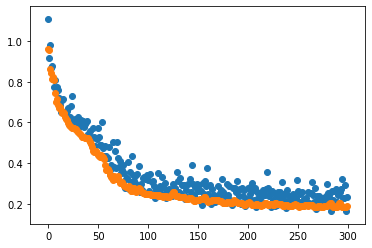

In [0]:
train_losses, test_losses = train(20)
plt.scatter(range(len(train_losses)), train_losses)
plt.scatter(range(len(test_losses)), test_losses)

In [0]:
 # Ответ на задачу 
model.train(False)
np.mean(test_losses)

0.2937270954251289